In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager

import emcee
import corner
import multiprocessing as mp
import os
from pybaselines import Baseline


In [ ]:
# Register the font
font_path = '/usr/share/fonts/liberation-sans/LiberationSans-Regular.ttf'
font_manager.fontManager.addfont(font_path)

# Get the actual family name (it must match the internal font name)
liberation = font_manager.FontProperties(fname=font_path)
font_name = liberation.get_name()  # usually "Liberation Sans"
print(font_name)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name]

plt.rcParams.update({
    'axes.linewidth': 0.5,      # axes spines
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.3,
    'ytick.minor.width': 0.3,
})

Liberation Sans


(0.0, 0.4)

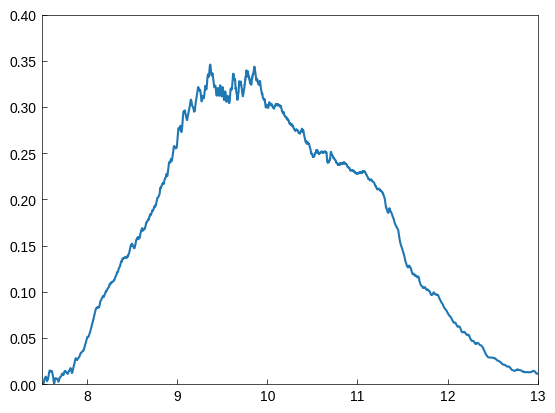

In [3]:
wv_total, tau_total, _ = np.genfromtxt('Spec_Emission_tau_B_revision.txt', unpack=True)
mask = wv_total < 23
wv_total = wv_total[mask]
tau_total = tau_total[mask]

plt.plot(wv_total, tau_total, label='Revision')
plt.xlim(7.5, 13)
plt.ylim(0, 0.4)

In [4]:
labels=['Olivine', 'Forsterite', 'Pyroxene', 'Enstatite', 'Silica', 'Quartz']
colors = ['r', 'brown', 'green', 'blue', 'fuchsia', 'orange', 'cyan']

tmp = np.genfromtxt('silicate_kabs_-dhs 0.99_-a 0.1 2.0_c 0.13.txt', skip_header=4)  # model optical depth for each silicate component

wv_sim = tmp[:,0]
Si_sim = tmp[:,1:7]

tmp = np.genfromtxt('silicate_kabs_-dhs 0.80_-a 0.1 2.0_c 0.13.txt', skip_header=4)  # model optical depth for each silicate component
Si_sim[:, 1] = tmp[:, 2]
Si_sim[:, 3] = tmp[:, 4]
Si_sim[:, 5] = tmp[:, 6]

tmp = np.genfromtxt('silicate_kabs_-dhs 0.80_-a 1.0 5.0_c 0.13.txt', skip_header=4)  # model optical depth for each silicate component
Si_sim[:, 3] = tmp[:, 4]

2280.7847013454502
4812.348235052935
3177.689109479653
1849.1645701832304
9162.729092438807
9222.364577375847


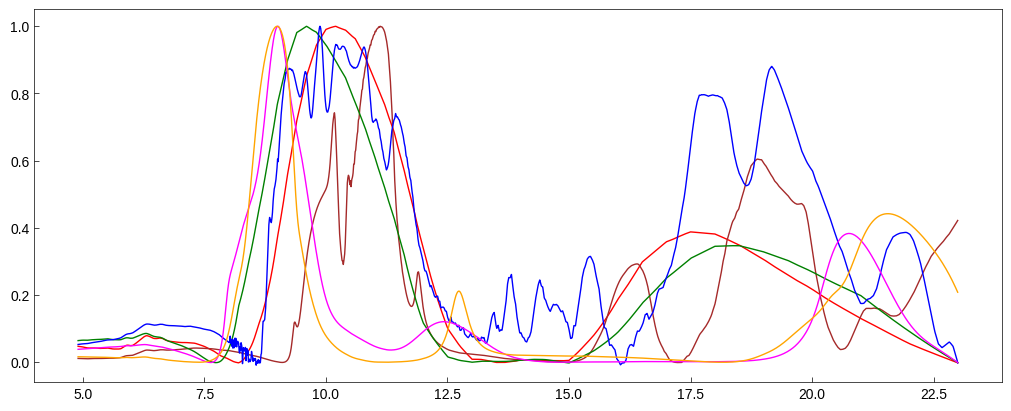

In [5]:
mask = wv_sim<23
Si_sim2 = Si_sim[mask, :]
wv_sim2 = wv_sim[mask]

Si_total = np.zeros((len(wv_total), 6))
norm_factor = np.zeros(6)

for i in range(6):

    baseline_fitter = Baseline(wv_sim2, check_finite=False)
    baseline, params = baseline_fitter.asls(Si_sim2[:, i], lam=5e8, p=1e-4)

    Si_sim2[:, i] -= baseline
    
    Si_total[:, i] = np.interp(wv_total, wv_sim2, Si_sim2[:, i])

    norm_factor[i] = np.max(Si_total[:, i])
    print(norm_factor[i])
    Si_total[:, i] /= np.max(Si_total[:, i])


fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
for i in range(len(Si_total[0])):
    plt.plot(wv_total, Si_total[:,i], label = labels[i], c=colors[i], lw=1)

# 10um

In [6]:
mask = (wv_total > 7.5) & (wv_total < 15)
wv_obs = wv_total[mask]
tau_obs = tau_total[mask]
Si= Si_total[mask, :]

for i in range(len(Si[0])):
    Si[:, i] = Si[:, i]/np.max(Si[:, i])

In [ ]:
sigma = 0.03  # uniform uncertainty for all data points


si_test = [0, 1, 2, 3, 4, 5]  # indices of Si to test, you can select which components to include in the model
ndim = len(si_test)

def log_likelihood(theta):
    model = np.zeros(len(wv_obs))
    for i in range(ndim):
        model += theta[i] * Si[:, si_test[i]] # linear combination of Si components
    return -0.5 * np.sum(((tau_obs - model) / sigma) ** 2)


def log_prior(theta):
    if np.all((theta > 0) & (theta < 1)):  # flat prior
        return 0.0

    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [8]:
si_test = [0, 1, 2, 3, 4, 5]  # indices of Si to test, you can select which components to include in the model
ndim = len(si_test)

nwalkers = 128
p0 = np.ones(ndim)*0.05 + 0.01 * np.random.randn(nwalkers, ndim)  # initial guess


num_cores=64  # number of cores to use, change to smaller numbers when using laptop
nsteps_burnin = 1000
nsteps = 5000 
with mp.Pool(num_cores) as pool:  # multicore processing for faster computation
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    state = sampler.run_mcmc(p0, nsteps_burnin) # burn-in, used to find the best starting point
    sampler.reset()

    sampler.run_mcmc(state, nsteps, progress=True) # real MCMC


# for single core processing
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
# sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 5000/5000 [00:25<00:00, 193.08it/s]


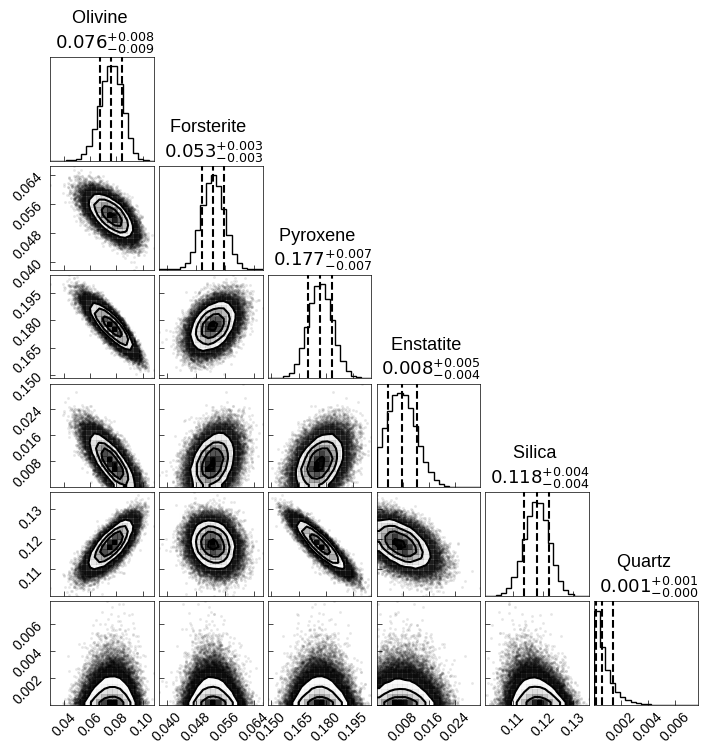

In [ ]:
samples = sampler.get_chain(thin=10, flat=True) # thinning to reduce number of samples(points) in the corner plot

mcmc_results = np.percentile(samples, [16, 50, 84], axis=0) # 16th, 50th, 84th percentiles, 1sigma

fig = plt.figure(figsize=(18.3/2.54, 18.3/2.54))

corner.corner(samples, labels=[labels[i] for i in si_test], quantiles=(0.16, 0.5, 0.84), label_kwargs={'fontsize': 7, 'alpha':0}, show_titles=True, title_kwargs={'fontsize': 7}, fig=fig, max_n_ticks=4, title_fmt='.3f')
axs = fig.get_axes()
for i in range(len(axs)):
    title = axs[i].get_title()
    if '=' in title:
        axs[i].set_title(title.replace('=', '\n'), fontsize=13)
plt.show()


fig.subplots_adjust(top=0.90, left=0.10, right=0.95, bottom=0.10)
fig.savefig('Final_FigExt5.pdf', bbox_inches=None)
fig.savefig('Final_FigExt5.jpeg', bbox_inches=None, dpi=300)

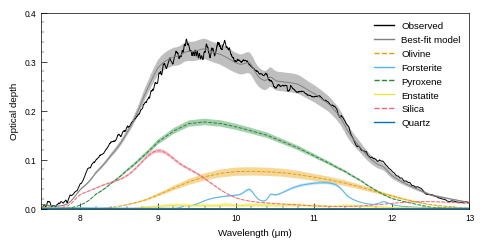

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12/2.54, 12/2.54 * 0.5), constrained_layout=True)

plt.plot(wv_obs, tau_obs, c='k', label='Observed', lw=0.7)



result_model = np.zeros(len(wv_obs))
result_up = np.zeros(len(wv_obs))
result_down = np.zeros(len(wv_obs))

for i in range(ndim):
    result_model += mcmc_results[1, i] * Si[:, si_test[i]]
    result_up += mcmc_results[2, i] * Si[:, si_test[i]]
    result_down += mcmc_results[0, i] * Si[:, si_test[i]]


plt.plot(wv_obs, result_model, c='gray', label='Best-fit model', lw=0.7)

plt.fill_between(wv_obs, result_down, result_up, alpha=0.5, color='gray', ec=None)

colors=['#e69f00', '#56b4e9', "#228833", '#f0e442', '#ee6677', '#0072b2']

for i in range(ndim):
    plt.fill_between(wv_obs, mcmc_results[0,i]*Si[:, si_test[i]], mcmc_results[2,i]*Si[:, si_test[i]], alpha=0.4, color=colors[si_test[i]], ec=None)

    if i%2 ==0:
        plt.plot(wv_obs, mcmc_results[1, i]*Si[:,si_test[i]], label=labels[si_test[i]], c=colors[si_test[i]], ls='--', lw=0.7)
    else:
        plt.plot(wv_obs, mcmc_results[1, i]*Si[:,si_test[i]], label=labels[si_test[i]], c=colors[si_test[i]], lw=0.7)
    

MSE = np.mean((tau_obs - result_model)**2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.tick_params(axis='both', which='major', labelsize=6, length=4, direction='in')
ax.tick_params(axis='both', which='minor', length=2, direction='in')
ax.set_xlabel('Wavelength (μm)', fontsize=7)
ax.set_ylabel(r'Optical depth', fontsize=7)

leg = ax.legend(fontsize=7, frameon=False)
for line in leg.get_lines():
    line.set_linewidth(1)

plt.xlim(np.min(wv_obs), np.max(wv_obs))
plt.xlim(7.5, 13)
plt.ylim(0, 0.4)

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

fig.set_size_inches(12/2.54, 12/2.54 * 0.5)
plt.savefig('Final_Fig2.pdf', bbox_inches=None)


In [14]:
print(mcmc_results[1, :])
print(norm_factor[:6])
mass = mcmc_results[1, :] / norm_factor[:6]
mass_low = mcmc_results[0, :] / norm_factor[:6]
mass_high = mcmc_results[2, :] / norm_factor[:6]
print(mass)

print(mass[1]/mass[0]*100, mass[1]/mass[0]*np.sqrt((mass_high[1]-mass[1])**2/mass[1]**2 + (mass_low[0]-mass[0])**2/mass[0]**2)*100, mass[1]/mass[0]*np.sqrt((mass_low[1]-mass[1])**2/mass[1]**2 + (mass_high[0]-mass[0])**2/mass[0]**2)*100)

print(mass[3]/mass[2]*100, mass[3]/mass[2]*np.sqrt((mass_high[3]-mass[3])**2/mass[3]**2 + (mass_low[2]-mass[2])**2/mass[2]**2)*100, mass[3]/mass[2]*np.sqrt((mass_low[3]-mass[3])**2/mass[3]**2 + (mass_high[2]-mass[2])**2/mass[2]**2)*100)

print(mass[5]/mass[4]*100, mass[5]/mass[4]*np.sqrt((mass_high[5]-mass[5])**2/mass[5]**2 + (mass_low[4]-mass[4])**2/mass[4]**2)*100, mass[5]/mass[4]*np.sqrt((mass_low[5]-mass[5])**2/mass[5]**2 + (mass_high[4]-mass[4])**2/mass[4]**2)*100)

[0.07625361 0.05281292 0.17683717 0.00763885 0.11802216 0.00053064]
[2280.78470135 4812.34823505 3177.68910948 1849.16457018 9162.72909244
 9222.36457738]
[3.34330581e-05 1.09744593e-05 5.56496136e-05 4.13097453e-06
 1.28806774e-05 5.75387142e-08]
32.825173407115265 4.249619369279197 4.025675081202394
7.42318637677665 4.48472037937067 4.084695662490018
0.44670565274883356 0.7208403083700482 0.3343511477624517


# 18um

In [15]:
mask = (wv_total > 15) & (wv_total < 23)

wv_obs = wv_total[mask]
tau_obs = tau_total[mask]
Si= Si_total[mask, :]

for i in range(len(Si[0])):
    Si[:, i] = Si[:, i]/np.max(Si[:, i])

In [ ]:
sigma = 0.01  # uniform uncertainty for all data points


si_test = [0, 1, 2, 3, 4, 5]  # indices of Si to test, you can select which components to include in the model
ndim = len(si_test)

def log_likelihood(theta):
    model = np.zeros(len(wv_obs))
    for i in range(ndim):
        model += theta[i] * Si[:, si_test[i]] # linear combination of Si components
    return -0.5 * np.sum(((tau_obs - model) / sigma) ** 2)

def log_prior(theta):
    if np.all((theta > 0) & (theta < 1)):  # flat prior
        return 0.0

    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [17]:
si_test = [0, 1, 2, 3, 4, 5]  # indices of Si to test, you can select which components to include in the model
ndim = len(si_test)

nwalkers = 128
p0 = np.ones(ndim)*0.05 + 0.01 * np.random.randn(nwalkers, ndim)  # initial guess


num_cores=64  # number of cores to use, change to smaller numbers when using laptop
nsteps_burnin = 1000
nsteps = 5000 
with mp.Pool(num_cores) as pool:  # multicore processing for faster computation
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    state = sampler.run_mcmc(p0, nsteps_burnin) # burn-in, used to find the best starting point
    sampler.reset()

    sampler.run_mcmc(state, nsteps, progress=True) # real MCMC


# for single core processing
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
# sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 5000/5000 [00:25<00:00, 197.77it/s]


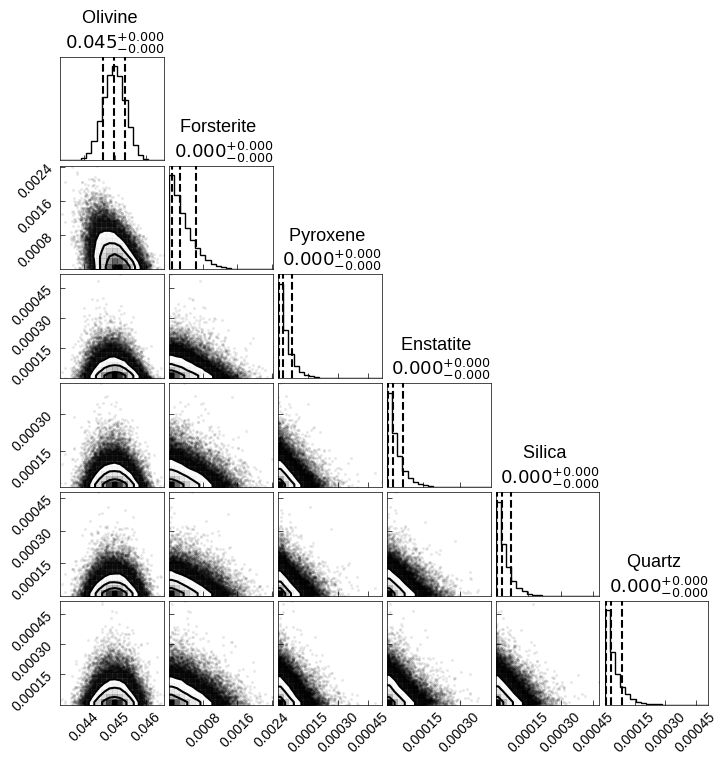

In [18]:
samples = sampler.get_chain(thin=10, flat=True) # thinning to reduce number of samples(points) in the corner plot

mcmc_results = np.percentile(samples, [16, 50, 84], axis=0) # 16th, 50th, 84th percentiles, 1sigma

fig = plt.figure(figsize=(18.3/2.54, 18.3/2.54))

corner.corner(samples, labels=[labels[i] for i in si_test], quantiles=(0.16, 0.5, 0.84), label_kwargs={'fontsize': 7, 'alpha':0}, show_titles=True, title_kwargs={'fontsize': 7}, fig=fig, max_n_ticks=4, title_fmt='.3f')
axs = fig.get_axes()
for i in range(len(axs)):
    title = axs[i].get_title()
    if '=' in title:
        axs[i].set_title(title.replace('=', '\n'), fontsize=13)
plt.show()


fig.subplots_adjust(top=0.90, left=0.10, right=0.95, bottom=0.10)
fig.savefig('Final_FigExt7.pdf', bbox_inches=None)
fig.savefig('Final_FigExt7.jpeg', bbox_inches=None, dpi=300)

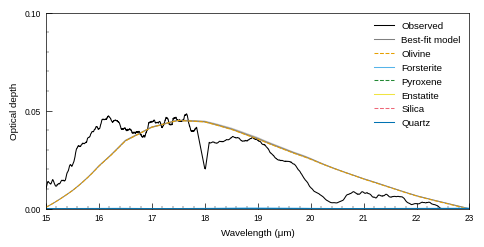

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12/2.54, 12/2.54 * 0.5), constrained_layout=True)

plt.plot(wv_obs, tau_obs, c='k', label='Observed', lw=0.75)


result_model = np.zeros(len(wv_obs))
result_up = np.zeros(len(wv_obs))
result_down = np.zeros(len(wv_obs))

for i in range(ndim):
    result_model += mcmc_results[1, i] * Si[:, si_test[i]]
    result_up += mcmc_results[2, i] * Si[:, si_test[i]]
    result_down += mcmc_results[0, i] * Si[:, si_test[i]]


plt.plot(wv_obs, result_model, c='gray', label='Best-fit model', lw=0.75)

plt.fill_between(wv_obs, result_down, result_up, alpha=0.5, color='gray', ec=None)

#colors=['#85A947', '#ACF400', "#B28029", '#FFD66B', '#547792', '#4DA8DA']

for i in range(ndim):
    plt.fill_between(wv_obs, mcmc_results[0,i]*Si[:, si_test[i]], mcmc_results[2,i]*Si[:, si_test[i]], alpha=0.3, color=colors[si_test[i]], ec=None)

    if i%2 ==0:
        plt.plot(wv_obs, mcmc_results[1, i]*Si[:,si_test[i]], label=labels[si_test[i]], c=colors[si_test[i]], ls='--', lw=0.75)
    else:
        plt.plot(wv_obs, mcmc_results[1, i]*Si[:,si_test[i]], label=labels[si_test[i]], c=colors[si_test[i]], lw=0.75)
    

MSE = np.mean((tau_obs - result_model)**2)


ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

ax.tick_params(axis='both', which='major', labelsize=6, length=4, direction='in')
ax.set_xlabel('Wavelength (μm)', fontsize=7, font=liberation)
ax.set_ylabel(r'Optical depth', fontsize=7, font=liberation)

ax.legend(fontsize=7, frameon=False)

plt.xlim(np.min(wv_obs), np.max(wv_obs))
plt.xlim(15, 23)
plt.ylim(0, 0.1)

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

fig.set_size_inches(12/2.54, 12/2.54 * 0.5)
plt.savefig('Final_FigExt6.pdf', bbox_inches=None)
plt.savefig('Final_FigExt6.jpeg', bbox_inches=None, dpi=300)
